### Background

• DOMAIN: Sports management

• CONTEXT: Company X is a sports management company for international cricket.

• DATA DESCRIPTION: The data is collected belongs to batsman from IPL series conducted so far. Attribute Information:

1. Runs: Runs score by the batsman
2. Ave: Average runs scored by the batsman per match
3. SR: strike rate of the batsman
4. Fours: number of boundary/four scored
5. Six: number of boundary/six scored
6. HF: number of half centuries scored so far

• PROJECT OBJECTIVE: Goal is to build a data driven batsman ranking model for the sports management company to make business decisions.

In [1]:
# Import libraries

import numpy as np
import pandas as pd

# Import libraries for Visualisation

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)
%matplotlib inline

from scipy.stats import zscore
from sklearn.decomposition import PCA

# To see multiple outputs together

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
# Load data

ipl = pd.read_csv('Part4 - batting_bowling_ipl_bat.csv')

# Check shape and size

print("The data has {} rows / observations and {} columns / features".format(ipl.shape[0],ipl.shape[1]))
print()
print('The size of the data is:', ipl.size)

The data has 180 rows / observations and 7 columns / features

The size of the data is: 1260


In [3]:
# Checking few rows to get sense of data

ipl.head()

,Name,Runs,Ave,SR,Fours,Sixes,HF
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,CH Gayle,733.0,61.08,160.74,46.0,59.0,9.0
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,G Gambhir,590.0,36.87,143.55,64.0,17.0,6.0
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN


There is presence of missing values. Looks like some rows are completely missing. We will check and perform missing value treatment.

In [4]:
# Check for missing values

pd.DataFrame( ipl.isnull().sum(), columns= ['Number of missing values'])

,Number of missing values
Name,90
Runs,90
Ave,90
SR,90
Fours,90
Sixes,90
HF,90


Each attribute has same number of missing values indicate that some rows are completely missing. We will drop those rows.

In [5]:
# Dropping missing values and verify if missing values have been dropped

ipl=ipl.dropna(axis=0)
pd.DataFrame( ipl.isnull().sum(), columns= ['Number of missing values'])

,Number of missing values
Name,0
Runs,0
Ave,0
SR,0
Fours,0
Sixes,0
HF,0


While there is no more missing values, we will check data-types to rule out any missing values in terms of special characters.

In [6]:
# Check data-types

ipl.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 90 entries, 1 to 179
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Name    90 non-null     object 
 1   Runs    90 non-null     float64
 2   Ave     90 non-null     float64
 3   SR      90 non-null     float64
 4   Fours   90 non-null     float64
 5   Sixes   90 non-null     float64
 6   HF      90 non-null     float64
dtypes: float64(6), object(1)
memory usage: 5.6+ KB


The above suggests that there is no special character in any attribute as attributes like run, ave etc are all float type.

In [7]:
##Identify duplicates records in the data
dupes = ipl.duplicated()
if sum(dupes) == 0:
    print("There is no duplicates in the data")
else:
    ipl = ipl.drop_duplicates()
    dupes_check = ipl.duplicated()
    sum(dupes_check)

There is no duplicates in the data


We have completed basic data checks and now we move to EDA.

### Exploratory Data Analaysis (EDA)

In [8]:
ipl.describe()

,Runs,Ave,SR,Fours,Sixes,HF
count,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000
mean,219.933333,24.729889,119.164111,19.788889,7.577778,1.188889
std,156.253669,13.619215,23.656547,16.399845,8.001373,1.688656
min,2.000000,0.500000,18.180000,0.000000,0.000000,0.000000
25%,98.000000,14.665000,108.745000,6.250000,3.000000,0.000000
50%,196.500000,24.440000,120.135000,16.000000,6.000000,0.500000
75%,330.750000,32.195000,131.997500,28.000000,10.000000,2.000000
max,733.000000,81.330000,164.100000,73.000000,59.000000,9.000000


* The average runs scored by players is 220.
* The maximum fours and sixes hit by any player is 73 and 59 respectively. On an average a player hits around 20 fours and 8 sixes.
* The median values of fours and sixes are less than the average indicating extreme values.

<Figure size 1080x864 with 0 Axes>

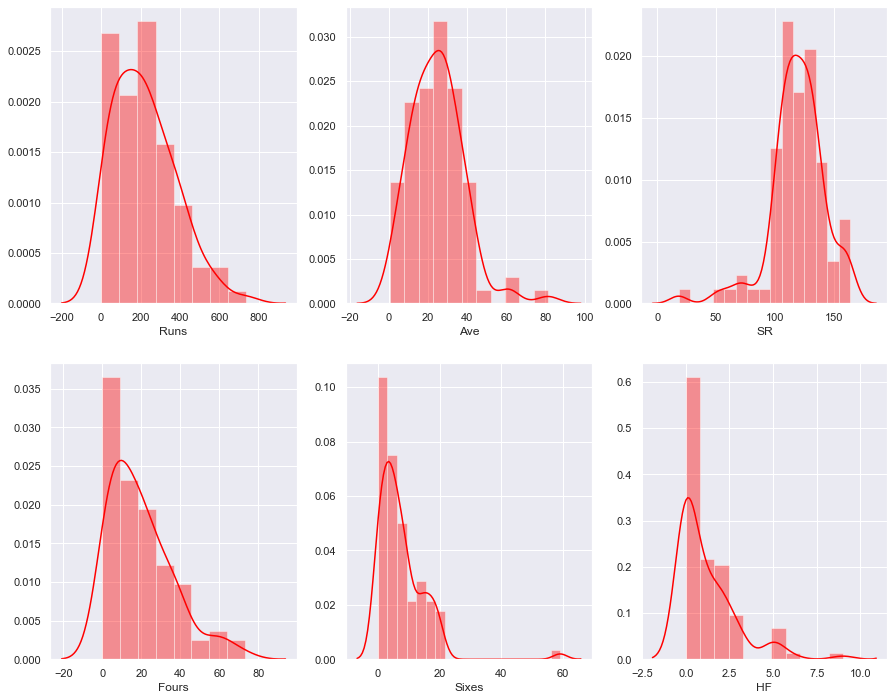

In [9]:
# Ditsribution of the attributes

plt.figure(figsize=(15, 12))
col = 1
for i in ipl.drop(columns='Name').columns:
    plt.subplot(2, 3, col)
    sns.distplot(ipl[i], color = 'red')
    col += 1 

* The skewness of the distribution suggests that there may be presenece of outliers, i.e. there are few batsmen who are very hard hitting and scoring more runs consistently.
* The distribution of most the attributes indicate that there is few clusters. This is also very evident as not all players will have same strength and each will have different playing pattern.

We will check for the outliers.

<Figure size 1080x720 with 0 Axes>

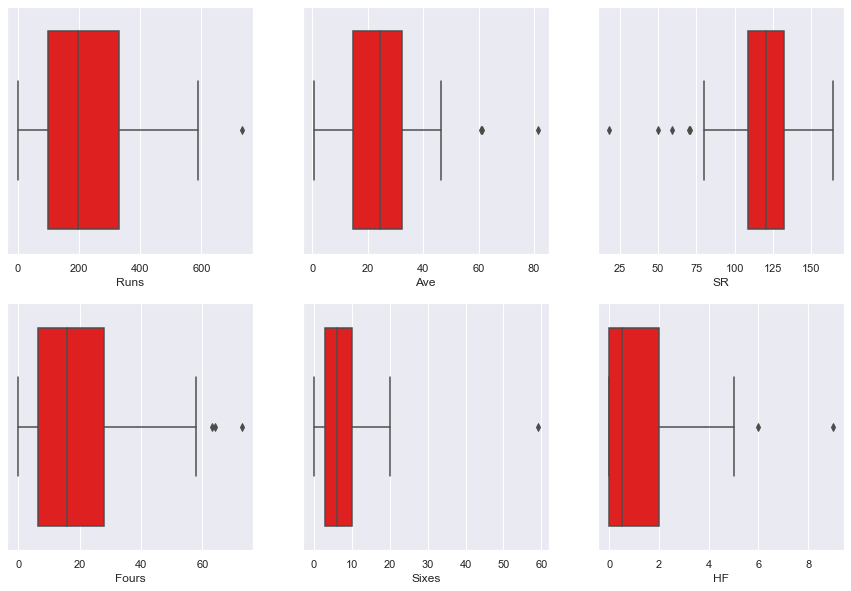

In [10]:
plt.figure(figsize=(15, 10))
col = 1
for i in ipl.drop(columns='Name').columns:
    plt.subplot(2, 3, col)
    sns.boxplot(ipl[i],color='red')
    col += 1

* As anticipated there's few outliers for each attribute. However, these seem legitimate and not data error as batting style of every batsmen is different.
* Also, here our object is to rank batsmen based on the batting attributes. Correcting outliers may alter that purpose.

We proceed below with pairplot and correlation analysis to see how the attributes are related to each other

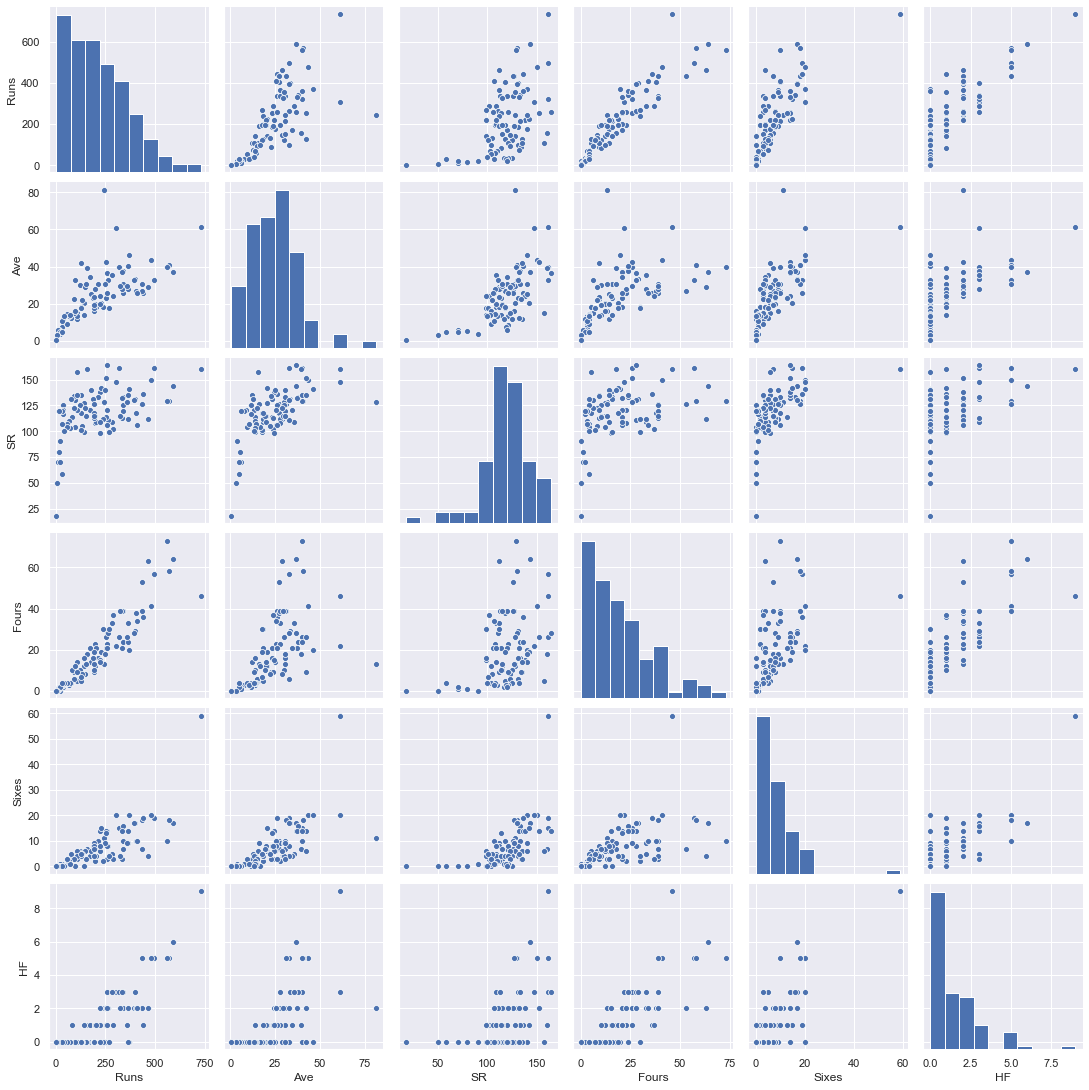

In [11]:
# Pair-plot
sns.pairplot(data=ipl);

* Runs and Average are positively correlated which is also evident because average increases with more runs scored
* Also, Runs have positive correlation with fours, sixes and HF. These are also pretty obvious
* We see a surprising result as there seems to no or very less correlation between fours / sixes and SR. With hitting fours and sixes the SR is supposed to go up. The reason could be presence of outliers on the lower range of SR.

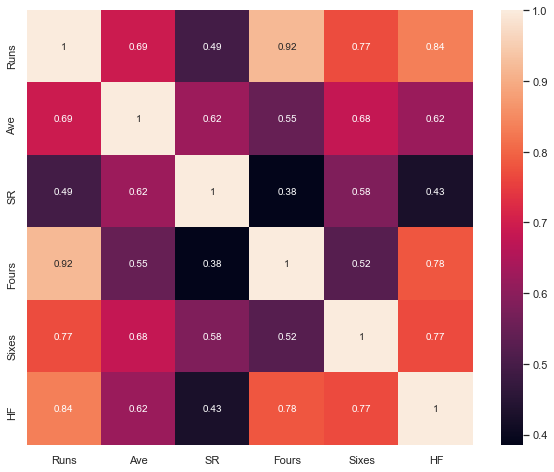

In [12]:
# Correlation
plt.figure(figsize=(10,8))
corr=ipl.drop(columns='Name').corr()
sns.heatmap(corr,annot=True);

* As derived from the pair-plot analyses most the attributes have strong positive correlation between themselves. Since all attributes are batting attributes this is very evident and does not require much explanation or reasoning.

While we would do further analysis to rank, we also do a quick check on who are the top batsmen based on each of the attributes. This will give us a direction that which batsmen are scoring consistently good on each attribute.

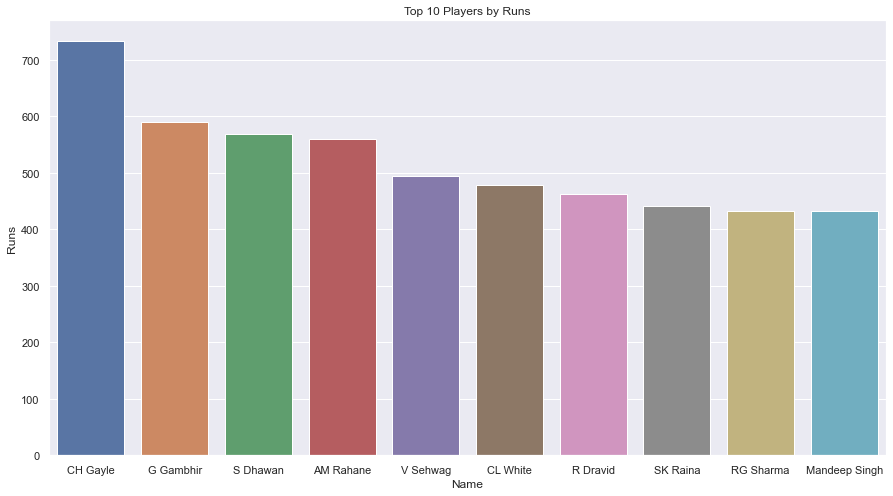

In [13]:
# Checking Top 10 batsmen based on Runs

plt.figure(figsize=(15,8))
ipl1=ipl.groupby('Name')['Runs'].sum().sort_values(ascending = False ).head(10)
ipl1= ipl1.reset_index() 
ipl1.columns = ['Name' ,'Runs']
sns.barplot(data= ipl1 , x= 'Name' , y ='Runs');
plt.title("Top 10 Players by Runs");

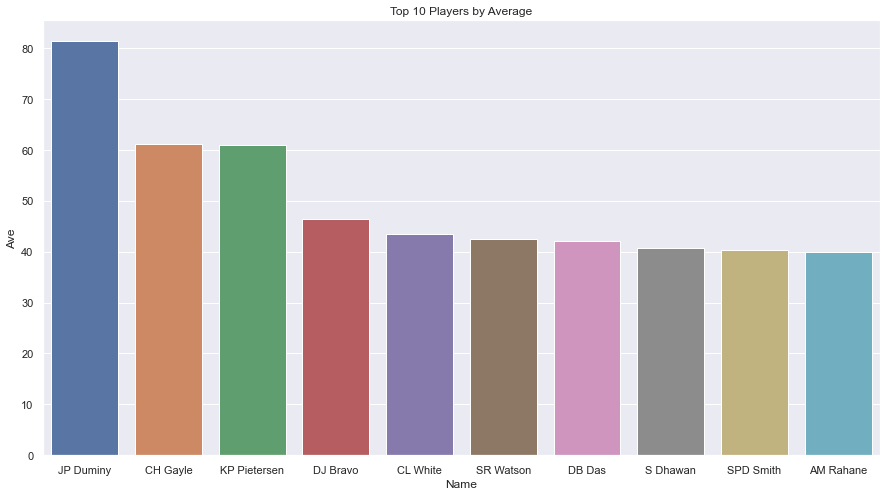

In [14]:
# Checking Top 10 batsmen based on Average

plt.figure(figsize=(15,8))
ipl1=ipl.groupby('Name')['Ave'].sum().sort_values(ascending = False ).head(10)
ipl1= ipl1.reset_index() 
ipl1.columns = ['Name' ,'Ave']
sns.barplot(data= ipl1 , x= 'Name' , y ='Ave');
plt.title("Top 10 Players by Average");

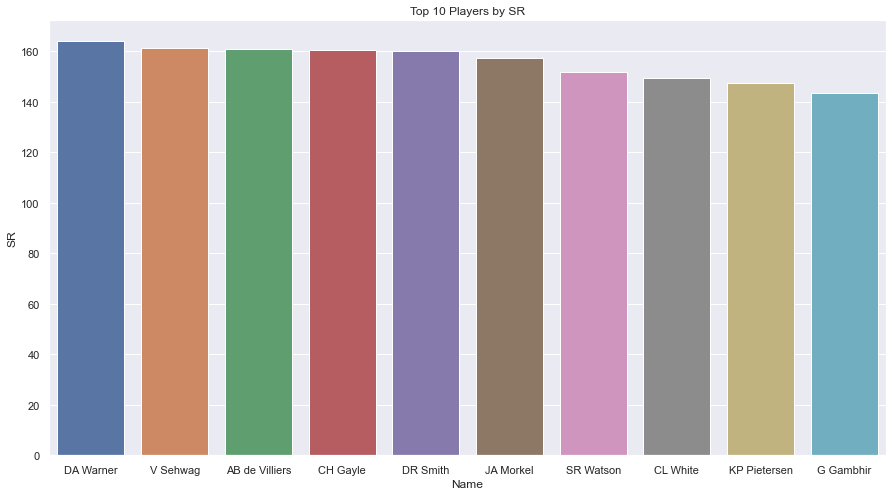

In [15]:
# Checking Top 10 batsmen based on SR

plt.figure(figsize=(15,8))
ipl1=ipl.groupby('Name')['SR'].sum().sort_values(ascending = False ).head(10)
ipl1= ipl1.reset_index() 
ipl1.columns = ['Name' ,'SR']
sns.barplot(data= ipl1 , x= 'Name' , y ='SR');
plt.title("Top 10 Players by SR");

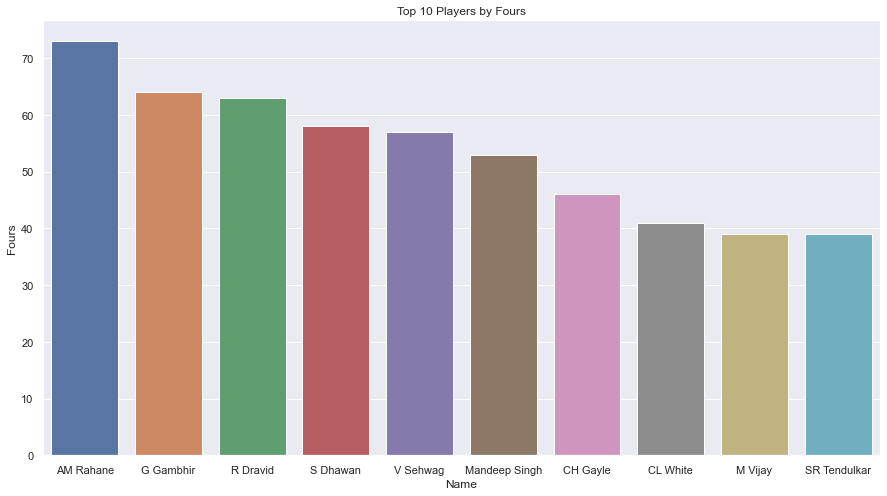

In [16]:
# Checking Top 10 batsmen based on Fours

plt.figure(figsize=(15,8))
ipl1=ipl.groupby('Name')['Fours'].sum().sort_values(ascending = False ).head(10)
ipl1= ipl1.reset_index() 
ipl1.columns = ['Name' ,'Fours']
sns.barplot(data= ipl1 , x= 'Name' , y ='Fours');
plt.title("Top 10 Players by Fours");

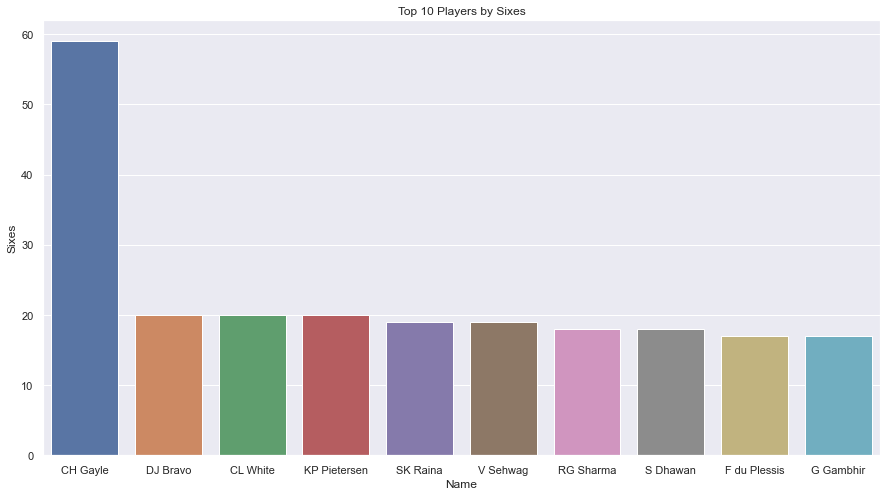

In [17]:
# Checking Top 10 batsmen based on Sixes

plt.figure(figsize=(15,8))
ipl1=ipl.groupby('Name')['Sixes'].sum().sort_values(ascending = False ).head(10)
ipl1= ipl1.reset_index() 
ipl1.columns = ['Name' ,'Sixes']
sns.barplot(data= ipl1 , x= 'Name' , y ='Sixes');
plt.title("Top 10 Players by Sixes");

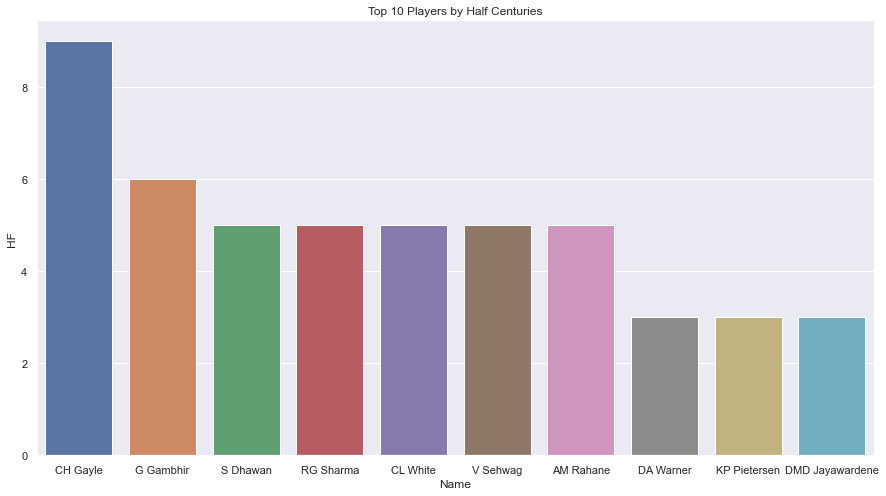

In [18]:
# Checking Top 10 batsmen based on HF

plt.figure(figsize=(15,8))
ipl1=ipl.groupby('Name')['HF'].sum().sort_values(ascending = False ).head(10)
ipl1= ipl1.reset_index() 
ipl1.columns = ['Name' ,'HF']
sns.barplot(data= ipl1 , x= 'Name' , y ='HF');
plt.title("Top 10 Players by Half Centuries");

Some batsmen like CH Gayle, G Gambhir, V Sehwag feature in the top 10 for most of the attributes. We will now move to rank them through some statistical techniques.

### Principal Component Analysis

In [19]:
# Scaling data before applying PCA

ipl_noname = ipl.copy()
ipl_noname = ipl_noname.drop('Name', axis=1)
ipl_scaled=ipl_noname.apply(zscore)

In [20]:
# Applying PCA and extracting the Eigen Values and Variance Explained

pca = PCA()
pca.fit(ipl_scaled)

print('The Eigen Values are: \n')
print(pca.explained_variance_)
print()

print('The variance explained by each component is: \n')
print(pca.explained_variance_ratio_)

PCA()

The Eigen Values are: 

[4.30252561 0.83636692 0.41665751 0.32912443 0.16567829 0.01706297]

The variance explained by each component is: 

[0.70911996 0.13784566 0.06867133 0.05424458 0.02730624 0.00281223]


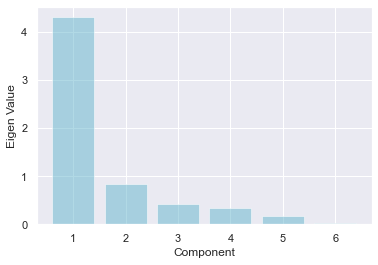

In [21]:
plt.bar(list(range(1,7)),pca.explained_variance_,alpha=0.5, align='center',color='c');
plt.ylabel('Eigen Value');
plt.xlabel('Component');
plt.show();

* Component 1 alone explains 71% of the variation.
* The corresponding eigen value is 4.3 and this is the only eigen value which is greater than 1.
* Hence we can choose 1st Principal Component to represent the data.

We will use the loading matrix to get the relationship of the components with different attributes.

In [22]:
loadings = pd.DataFrame(pca.components_.T,columns=['PC1', 'PC2','PC3','PC4','PC5','PC6'],index=['Runs','Ave','SR','Fours','Sixes','HF'])
loadings

,PC1,PC2,PC3,PC4,PC5,PC6
Runs,0.458261,0.266432,-0.109779,-0.005201,0.458409,0.704836
Ave,0.397973,-0.331118,0.005505,0.847363,-0.101228,-0.060637
SR,0.325384,-0.697803,-0.450134,-0.432750,-0.118903,0.056249
Fours,0.405742,0.473558,-0.508235,-0.032523,0.096769,-0.585142
Sixes,0.417335,-0.179025,0.669426,-0.248782,0.394580,-0.357862
HF,0.432372,0.275932,0.280825,-0.178118,-0.774867,0.160962


We follow the below steps to decide the ranks of batsmen:

1. For each batsman we compute a score as:

        Score = 0.458 x Runs + 0.398 x Ave + 0.325 x SR + 0.406 x Fours + 0.417 x Sixes + 0.432 x HF

    Since there is no negative direction here, higher the score better will be the player.
    

2. We rank them based on the score, i.e. higher score gets better rank. Example highest score is rank 1, second highest is rank 2 and so on.


3. We sort the data in ascending order based on the rank value.

Note : If we had taken more components we should have weighted the score as per the variance explianed by the components.

In [23]:
# Adding Score to original data

ipl['Score'] = 0.458 * ipl['Runs'] + 0.398 * ipl['Ave'] + 0.325 * ipl['SR'] + 0.406 * ipl['Fours'] + 0.417 * ipl['Sixes'] + 0.432 * ipl['HF']

In [24]:
# Check the above operation through head

ipl.head()

,Name,Runs,Ave,SR,Fours,Sixes,HF,Score
1,CH Gayle,733.0,61.08,160.74,46.0,59.0,9.0,459.43134
3,G Gambhir,590.0,36.87,143.55,64.0,17.0,6.0,367.21301
5,V Sehwag,495.0,33.00,161.23,57.0,19.0,5.0,325.46875
7,CL White,479.0,43.54,149.68,41.0,20.0,5.0,312.50292
9,S Dhawan,569.0,40.64,129.61,58.0,18.0,5.0,352.11397


In [25]:
# creating a rank column based on Score
ipl["Rank"] = ipl["Score"].rank(ascending=False)

In [26]:
# sorting w.r.t Rank column
ipl.sort_values("Rank", inplace = True)

In [28]:
# Top 10 batsmen

print('Top 10 batsmen are :\n')

ipl.head(10)

Top 10 batsmen are :



,Name,Runs,Ave,SR,Fours,Sixes,HF,Score,Rank
1,CH Gayle,733.0,61.08,160.74,46.0,59.0,9.0,459.43134,1.0
3,G Gambhir,590.0,36.87,143.55,64.0,17.0,6.0,367.21301,2.0
9,S Dhawan,569.0,40.64,129.61,58.0,18.0,5.0,352.11397,3.0
11,AM Rahane,560.0,40.00,129.33,73.0,10.0,5.0,350.40025,4.0
5,V Sehwag,495.0,33.00,161.23,57.0,19.0,5.0,325.46875,5.0
7,CL White,479.0,43.54,149.68,41.0,20.0,5.0,312.50292,6.0
39,R Dravid,462.0,28.87,112.13,63.0,4.0,2.0,287.63851,7.0
33,SK Raina,441.0,25.94,135.69,36.0,19.0,1.0,279.37237,8.0
15,RG Sharma,433.0,30.92,126.60,39.0,18.0,5.0,277.26516,9.0
37,Mandeep Singh,432.0,27.00,126.31,53.0,7.0,2.0,274.95375,10.0
